## AuxTel test LTS-337-015 (Small Slew and Settle)

In this notebook, we check the speed and accuracy of the slew and settle of the telescope with a
change of 10 degrees.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The pointing accuracy requirement for small slews is:    | 2.5       | Arcsec RMS   |Aux_Tel_Sm_Slew_Abs_Pointing|
The small elevation slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement| 10| Degrees |Aux_Tel_Sm_Elev_Slew|
|The small azimuth slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement.  |10       | Degrees     |Aux_Tel_Sm_Az_Slew|
|The allotted time to perform a slew and settle by Aux_Tel_Sm_Elev_Slew and Aux_Tel_Sm_Az_Slew by the Auxiliary Telescope and meet the Aux_Tel_Sm_Slew_Abs_Pointing pointing requirement.      | 10|Seconds|Aux_Tel_Smslew_AcqTime|

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lsst.ts import salobj
from lsst.ts.observatory.control.auxtel.atcs import ATCS
from lsst.ts.observatory.control.auxtel.latiss import LATISS
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from lsst_efd_client import EfdClient


Bad key "text.kerning_factor" on line 4 in
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Set Cerro Pachon location
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [3]:
# for tab completion to work in current notebook instance
%config IPCompleter.use_jedi = False

In [4]:
import logging
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [6]:
# Get EFD client and bring in Lupton's unpacking code
client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"):
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253
Starting new HTTPS connection (1): roundtable.lsst.codes:443
https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 92


In [8]:
#get classes and start them
domain = salobj.Domain()
await asyncio.sleep(10) # This can be removed in the future...
atcs = ATCS(domain)
latiss = LATISS(domain)
await asyncio.gather(atcs.start_task, latiss.start_task)

atmcs: Adding all resources.
atptg: Adding all resources.
ataos: Adding all resources.
atpneumatics: Adding all resources.
athexapod: Adding all resources.
atdome: Adding all resources.
atdometrajectory: Adding all resources.
atcamera: Adding all resources.
atspectrograph: Adding all resources.
atheaderservice: Adding all resources.
atarchiver: Adding all resources.
Read historical data in 0.00 sec
Read 1 history items for RemoteEvent(ATHeaderService, 0, authList)
Read 100 history items for RemoteEvent(ATHeaderService, 0, heartbeat)
Read 9 history items for RemoteEvent(ATHeaderService, 0, largeFileObjectAvailable)
Read 1 history items for RemoteEvent(ATHeaderService, 0, logLevel)
Read 100 history items for RemoteEvent(ATHeaderService, 0, logMessage)
Read 1 history items for RemoteEvent(ATHeaderService, 0, simulationMode)
Read 1 history items for RemoteEvent(ATHeaderService, 0, softwareVersions)
Read 21 history items for RemoteEvent(ATHeaderService, 0, summaryState)
Read historical data

[[None, None, None, None, None, None, None], [None, None, None, None]]

In [97]:
# enable components if required
await atcs.enable()
await latiss.enable()

Enabling all components
Gathering settings.
atdome check is disabled, skipping.
atdometrajectory check is disabled, skipping.
Couldn't get settingVersions event. Using empty settings.
Complete settings for atmcs.
Complete settings for atptg.
Complete settings for ataos.
Complete settings for atpneumatics.
Complete settings for athexapod.
Settings versions: {'atmcs': '                                                                                                                               ', 'atptg': '', 'ataos': 'current', 'atpneumatics': '                                                                                                                               ', 'athexapod': 'summit'}
[atmcs]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atptg]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[ataos]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[atpneumatics]::[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]
[athex

In [98]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [99]:
# turn on ATAOS corrections just to make sure the mirror is under air
tmp = await atcs.rem.ataos.cmd_enableCorrection.set_start(m1=True, hexapod=True, atspectrograph=False)

In [100]:
# Ensure we're using Nasmyth 2
await atcs.rem.atptg.cmd_focusName.set_start(focus=3)

In [91]:
# point telescope to desired starting position
start_az=0
start_el=70
start_rot_pa=0
await atcs.point_azel(start_az, start_el, rot_tel=start_rot_pa, wait_dome=False)

Sending command
Stop tracking.
Unknown tracking state: 10
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
Got False
Telescope not in position
[Telescope] delta Alt = +012.623 deg; delta Az= +057.662 deg; delta N1 = +000.000 deg; delta N2 = -105.242 deg 
[Telescope] delta Alt = +012.497 deg; delta Az= +056.025 deg; delta N1 = +000.000 deg; delta N2 = -102.610 deg 
[Telescope] delta Alt = +009.423 deg; delta Az= +050.054 deg; delta N1 = +000.000 deg; delta N2 = -096.609 deg 
[Telescope] delta Alt = +003.694 deg; delta Az= +044.055 deg; delta N1 = +000.000 deg; delta N2 = -090.607 deg 
[Telescope] delta Alt = +000.239 deg; delta Az= +038.054 deg; delta N1 = +000.000 deg; delta N2 = -086.615 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= +034.055 deg; delta N1 = +000.000 deg; delta N2 = -082.609 deg 
[Telescope] delta Alt = -000.000 deg; del

In [101]:
#declare offset sizes for tests

# For small slew and settle
d_az= 10 # degrees
d_el = 10 # degrees
d_rot= 0 # degrees

"""
# For large slew and settle
d_az= 90 # degrees
d_el = 60 # degrees
d_rot= 0 # degrees

# What we actually care about for the survey! So measure this too
d_az= 3.5 # degrees
d_el = 3.5 # degrees
d_rot= 0 # degrees
"""

'\n# For large slew and settle\nd_az= 90 # degrees\nd_el = 60 # degrees\nd_rot= 0 # degrees\n\n# What we actually care about for the survey! So measure this too\nd_az= 3.5 # degrees\nd_el = 3.5 # degrees\nd_rot= 0 # degrees\n'

In [102]:
# get RA/DEC of current telescope Alt/Az position
az = Angle(start_az, unit=u.deg)
el = Angle(start_el, unit=u.deg)
print(f'orig az {az} and el {el}')
time_data = await atcs.rem.atptg.tel_timeAndDate.next(flush=True, timeout=2)
# This should be TAI and not UTC... so will be 37s off system clock seconds ??
curr_time_atptg = Time(time_data.mjd, format="mjd")

coord_frame_AltAz = AltAz(location=location, obstime=curr_time_atptg)
coord_frame_radec = ICRS()
coord_azel = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec = coord_azel.transform_to(coord_frame_radec)
print('Current Position is: \n {}'.format(coord_azel))
print('Current Position is: \n {}'.format(ra_dec))

# get RA/DEC of target position
az = Angle(start_az+d_az, unit=u.deg)
el = Angle(start_el+d_el, unit=u.deg)
print(f'target az {az} and el {el}')
coord_azel_target = AltAz(az=az, alt=el, location=location, obstime=curr_time_atptg)
ra_dec_target = coord_azel_target.transform_to(coord_frame_radec)
print('Target Position is: \n {}'.format(coord_azel_target))
print('Target Position is: \n {}'.format(ra_dec_target))

orig az 0.0 deg and el 70.0 deg
Current Position is: 
 <AltAz Coordinate (obstime=59256.783597232876, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (0., 70.)>
Current Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (353.13069919, -10.3573162)>
target az 10.0 deg and el 80.0 deg
Target Position is: 
 <AltAz Coordinate (obstime=59256.783597232876, location=(1819093.56876225, -5208411.6827961, -3195180.61110659) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (10., 80.)>
Target Position is: 
 <ICRS Coordinate: (ra, dec) in deg
    (354.9728901, -20.49647723)>


In [103]:
# Slew to starting position and take an image to check headers
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)


Auto sky angle: 0.0 deg
Sending command
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = -009.904 deg; delta Az= +000.234 deg; delta N1 = +000.000 deg; delta N2 = +068.764 deg 
[Telescope] delta Alt = -008.538 deg; delta Az= +000.004 deg; delta N1 = +000.000 deg; delta N2 = +064.008 deg 
[Telescope] delta Alt = -003.112 deg; delta Az= +000.008 deg; delta N1 = +000.000 deg; delta N2 = +058.036 deg 
[Telescope] delta Alt = -000.042 deg; delta Az= +000.008 deg; delta N1 = +000.000 deg; delta N2 = +052.073 deg 
[Telescope] delta Alt = +000.000 deg; delta Az= +000.007 deg; delta N1 = +000.000 deg; delta N2 = +046.102 deg 
[Telescope] delta Alt = +000.000 deg; delta Az= +000.007 deg; delta N1 = +000.000 deg; delta N2 = +040.133 deg 
[Telescope] delta Alt = -000.000 deg; delta Az= +000.008 deg; delta N1 = +000.000 deg; delta N2

array([2021021100003])

In [7]:
# Check tracking
end_time = Time('2021-02-11T18:49:30.484', format='fits', scale='tai')
t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
await asyncio.sleep(6)
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]

200: SELECT * FROM "efd"."autogen"."lsst.sal.ATPtg.mount_positions" WHERE time >= '2021-02-11T18:49:30.484Z' AND time <= '2021-02-11T18:49:32.484Z'
Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [ ]:
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals - ra_dec_target.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec_target.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")


update_title_pos
Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
update_title_pos
Embedding font /opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
Writing TrueType font.
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


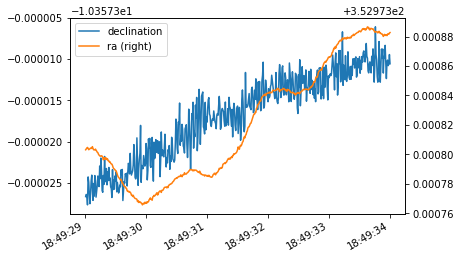

In [105]:
dec['declination'].plot(legend=True)
ra['ra'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/RA_Dec_Trends_Take2_11Feb21.pdf")

In [28]:
az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1)
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1)

update_title_pos
Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
update_title_pos
Embedding font /opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
Writing TrueType font.
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


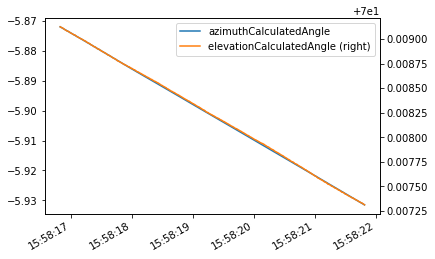

target python read queue is filling: 11 of 100 elements


In [29]:
az['azimuthCalculatedAngle'].plot(legend=True)
el['elevationCalculatedAngle'].plot(legend=True, secondary_y=True)
plt.savefig("/home/craiglagegit/DATA/Az_El_Trends_11Feb21.pdf")

In [33]:
len(dec_vals)

500

In [52]:
dec_time_vals = np.array(dec.values.tolist())[:,1]
ra_time_vals = np.array(ra.values.tolist())[:,1]

update_title_pos
update_title_pos
update_title_pos
update_title_pos


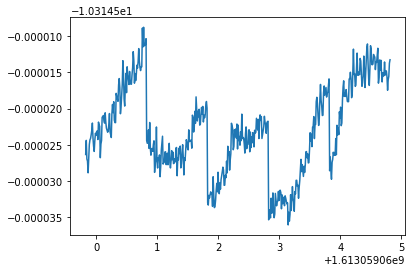

In [36]:
plt.plot(dec_time_vals, dec_vals)

update_title_pos
update_title_pos
update_title_pos
update_title_pos


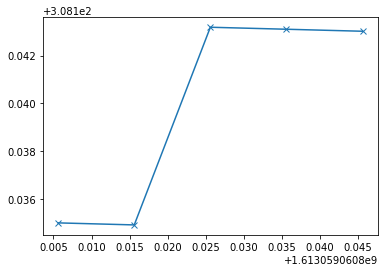

In [53]:
plt.plot(ra_time_vals[98:103], ra_vals[98:103], marker='x')

In [54]:
ra_vals[98:103]

array([308.13499934, 308.13491427, 308.14318803, 308.14310433,
       308.14302026])

In [50]:
new_dec_vals = np.zeros([500])
new_ra_vals = np.zeros([500])
for i in range(5):
    for j in range(100):
        index = i * 100 + j
        new_index = i * 100 + (99 - j)
        if i % 2 == 0:
            new_dec_vals[index] = dec_vals[new_index]
            new_ra_vals[index] = ra_vals[new_index]
        else:
            new_dec_vals[index] = dec_vals[index]
            new_ra_vals[index] = ra_vals[index]

    

update_title_pos
Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
update_title_pos
Embedding font /opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
Writing TrueType font.
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


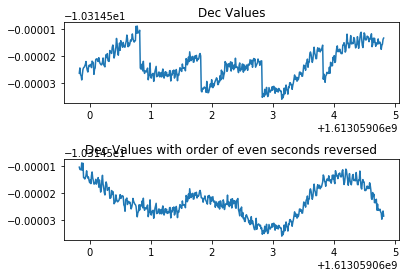

target python read queue is filling: 10 of 100 elements


In [65]:
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.7)
plt.title("Dec Values")
plt.plot(dec_time_vals, dec_vals)
plt.subplot(2,1,2)
plt.title("Dec Values with order of even seconds reversed")
plt.plot(dec_time_vals, new_dec_vals)
plt.savefig("/home/craiglagegit/DATA/Dec_Reversal_11Feb21.pdf")

update_title_pos
update_title_pos
update_title_pos
update_title_pos


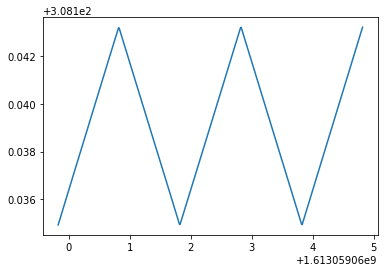

In [51]:
plt.plot(dec_time_vals, new_ra_vals)

In [56]:
t1 = Time('2021-02-11T15:58:18.533', scale='tai')
t2 = t1 + TimeDelta(1, format='sec', scale='tai')
df = await client.select_time_series('lsst.sal.ATPtg.mount_positions', '*', t1, t2)


200: SELECT * FROM "efd"."autogen"."lsst.sal.ATPtg.mount_positions" WHERE time >= '2021-02-11T15:58:18.533Z' AND time <= '2021-02-11T15:58:19.533Z'


In [61]:
print(df['ra99'],df['ra0'])

2021-02-11 15:58:18.587000+00:00    308.134914
Name: ra99, dtype: float64 2021-02-11 15:58:18.587000+00:00    308.143204
Name: ra0, dtype: float64


In [ ]:
# This is where the tests are carried out.
times = []
ra_accuracies = []
dec_accuracies = []

# Slew to starting position
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)


print('track for 2s')
await asyncio.sleep(2)
# take a quick image to get some header data
await latiss.take_engtest(exptime=1)

# Now slew to new target
print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec_target.ra), dec=str(ra_dec_target.dec),
                      rot=d_rot, slew_timeout=240., 
                      stop_before_slew=False, wait_settle=False)
end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec_target.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec_target.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")

# Repeat this going back to origin

print('Starting to Slew to target')
start_time = Time(Time.now(), format='fits', scale='tai')
await atcs.slew_icrs(ra=str(ra_dec.ra), dec=str(ra_dec.dec), rot=0.0,
                      slew_timeout=240., stop_before_slew=False, wait_settle=False)

end_time = Time(Time.now(), format='fits', scale='tai')
slew_time = TimeDelta(end_time - start_time, format='sec').value
print(f'Time to slew is {slew_time} seconds')
times.append(slew_time)
await latiss.take_engtest(exptime=1)

t_end = end_time + TimeDelta(2, format='sec')
nsec = 2
mount_position = await client.select_time_series("lsst.sal.ATPtg.mount_positions", ['*'],
                                          t_end - TimeDelta(nsec, format='sec'), t_end)
ra = merge_packed_time_series(mount_position, 'ra', stride=1)
dec = merge_packed_time_series(mount_position, 'declination', stride=1)
ra_vals = np.array(ra.values.tolist())[:,0]
dec_vals = np.array(dec.values.tolist())[:,0]
# Errors in arcsec
ra_rms = np.sqrt(np.mean((ra_vals*15.0 - ra_dec.ra.value)**2)) * 3600.0 
dec_rms = np.sqrt(np.mean((dec_vals - ra_dec.dec.value)**2)) * 3600.0 
ra_accuracies.append(ra_rms)
dec_accuracies.append(dec_rms)
print(f"RA rms = {ra_rms}. Dec rms = {dec_rms}.")



In [ ]:
# Now check to see if the specs are met:
Aux_Tel_Smslew_AcqTime = 10.0
if max(times) < Aux_Tel_Smslew_AcqTime:
    print(f"Aux_Tel_Smslew_AcqTime passed.  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")
else:
    print(f"Aux_Tel_Smslew_AcqTime failed!  Spec = {Aux_Tel_Smslew_AcqTime}.\
    Measured = {max(times)} ")

Aux_Tel_Sm_Slew_Abs_Pointing = 2.5
worst_case = max(ra_accuracies + dec_accuracies)
if worst_case < Aux_Tel_Sm_Slew_Abs_Pointing:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing passed.  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")
else:
    print(f"Aux_Tel_Sm_Slew_Abs_Pointing failed!  Spec = {Aux_Tel_Sm_Slew_Abs_Pointing}. \
    Measured = {worst_case} ")


In [67]:
#await salobj.set_summary_state(atcs.rem.atptg, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [68]:
#await salobj.set_summary_state(atcs.rem.atmcs, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [106]:
# For shutdown of system
await atcs.stop_tracking()

Stop tracking.
Unknown tracking state: 9
Unknown tracking state: 10
In Position: True.


In [107]:
# turn off corrections
tmp = await atcs.rem.ataos.cmd_disableCorrection.set_start(m1=True, hexapod=True, atspectrograph=True)

In [108]:
# Putting everything back in standby.
await atcs.shutdown()

Disabling ATAOS corrections
Disabling ATAOS corrections.
Closing M1 cover vent gates.
Cover state <MirrorCoverState.CLOSED: 6>
M1 cover already closed.
M1 vent state <VentsPosition.CLOSED: 1>
M1 vents already closed.
Skipping closing dome shutter and slewing dome to park position.
Disable ATDomeTrajectory
Slew telescope to Park position.
Sending command
Stop tracking.
Scheduling check coroutines
process as completed...
atmcs: <State.ENABLED: 2>
atptg: <State.ENABLED: 2>
ataos: <State.ENABLED: 2>
atpneumatics: <State.ENABLED: 2>
athexapod: <State.ENABLED: 2>
[Telescope] delta Alt = +010.200 deg; delta Az= +010.780 deg; delta N1 = -000.000 deg; delta N2 = -079.113 deg 
[Telescope] delta Alt = +010.067 deg; delta Az= +010.446 deg; delta N1 = -000.000 deg; delta N2 = -076.983 deg 
[Telescope] delta Alt = +006.391 deg; delta Az= +006.228 deg; delta N1 = +000.000 deg; delta N2 = -070.992 deg 
[Telescope] delta Alt = +001.119 deg; delta Az= +001.058 deg; delta N1 = +000.000 deg; delta N2 = -0

In [109]:
# take event checking out the slew commands to test telescope only
# otherwise it'll wait for the dome before completing slew command
atcs.check.atdome = False
atcs.check.atdometrajectory = False

In [110]:
await atcs.rem.atdome.cmd_start.set_start(settingsToApply="test", timeout=30)

In [111]:
await salobj.set_summary_state(atcs.rem.atdome, salobj.State.STANDBY, settingsToApply="test")

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [112]:
await salobj.set_summary_state(atcs.rem.atdometrajectory, salobj.State.STANDBY)

[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [113]:
await salobj.set_summary_state(latiss.rem.atspectrograph, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atcamera, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atheaderservice, salobj.State.STANDBY)
await salobj.set_summary_state(latiss.rem.atarchiver, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]